In [3]:
import gc
from functools import partial

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from transformers import GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

In [4]:
dataset = load_dataset("allenai/c4", "realnewslike")
subset = Subset(dataset["train"], torch.arange(1000))

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
# https://github.com/pytorch/pytorch/blob/aa7be72cc55244978ddaf760338dab6b9cf977a1/torch/nn/modules/rnn.py#L631
torch.nn.LSTM

torch.nn.modules.rnn.LSTM

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [7]:
drop_characters = {',', 'the', 'a'}

def preprocess_batched_text(batch, max_length: int = 10000):
    # print("Max len:", max_length)
    text_batch = []
    for text in batch["text"]:
        text_batch.append(''.join([x for x in text if x not in drop_characters]))
    max_length = min(max(len(x) for x in text_batch), max_length)
    encodings = tokenizer(
        text_batch,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    input_ids = encodings.input_ids.squeeze(0)
    return {
        "input_ids": input_ids[:, :-1],
        "targets": input_ids[:, 1:],
        "attention_mask": encodings.attention_mask.squeeze(0)[:, :-1],
    }

res = preprocess_batched_text(subset[:100])
{key: value.shape for key, value in res.items()}

{'input_ids': torch.Size([100, 9999]),
 'targets': torch.Size([100, 9999]),
 'attention_mask': torch.Size([100, 9999])}

In [8]:
def collate_fn(examples: list[dict], max_length: int):
    text = [x['text'] for x in examples]
    return preprocess_batched_text({'text': text}, max_length=max_length)

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.linear(x)
        return x, hidden

def train(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    model.train()

    targets = None
    input_ids = None
    output = None
    loss = None

    total_loss = 0
    total_examples = 0
    average_loss = 0
    perplexity = 0
    grad_norms = []
    for epoch in range(epochs):
        
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()
            del targets
            del input_ids
            del output
            del loss

            gc.collect()
            torch.cuda.empty_cache()
            torch.mps.empty_cache()

            targets = batch['targets'].contiguous().to(device)
            input_ids = batch['input_ids'].contiguous().to(device)
            # Forward pass
            output, _ = model(input_ids)
            loss = criterion(output.view(-1, model.linear.out_features), targets.view(-1))

            # Backward and optimize
            loss.backward()
            total_norm = 0
            for p in model.parameters():
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            grad_norms.append(total_norm)

            total_loss += loss.item() * input_ids.size(0)
            total_examples += input_ids.size(0)
            optimizer.step()

            if batch_idx % 10 == 0:
                average_loss = total_loss / total_examples
                perplexity = torch.exp(torch.tensor(average_loss))
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}, Perplexity: {perplexity.item()}')
        average_loss = total_loss / total_examples
        perplexity = torch.exp(torch.tensor(average_loss))
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Perplexity: {perplexity.item()}')
    return average_loss, perplexity, grad_norms


Number of batches in an epoch: 500
input_ids shape: torch.Size([2, 499])
targets shape: torch.Size([2, 499])
Epoch [1/2], Step [1/500], Loss: 10.8143, Perplexity: 49729.04296875
Epoch [1/2], Step [11/500], Loss: 9.0177, Perplexity: 23828.669921875
Epoch [1/2], Step [21/500], Loss: 4.6563, Perplexity: 7339.20458984375
Epoch [1/2], Step [31/500], Loss: 7.7405, Perplexity: 3458.179443359375
Epoch [1/2], Step [41/500], Loss: 7.7426, Perplexity: 1998.533935546875
Epoch [1/2], Step [51/500], Loss: 7.4209, Perplexity: 1397.13623046875
Epoch [1/2], Step [61/500], Loss: 5.1746, Perplexity: 994.0478515625
Epoch [1/2], Step [71/500], Loss: 5.6142, Perplexity: 928.0446166992188
Epoch [1/2], Step [81/500], Loss: 4.6567, Perplexity: 818.1487426757812
Epoch [1/2], Step [91/500], Loss: 7.7528, Perplexity: 778.0662841796875
Epoch [1/2], Step [101/500], Loss: 4.0855, Perplexity: 639.448486328125
Epoch [1/2], Step [111/500], Loss: 4.4955, Perplexity: 550.564453125
Epoch [1/2], Step [121/500], Loss: 7.488

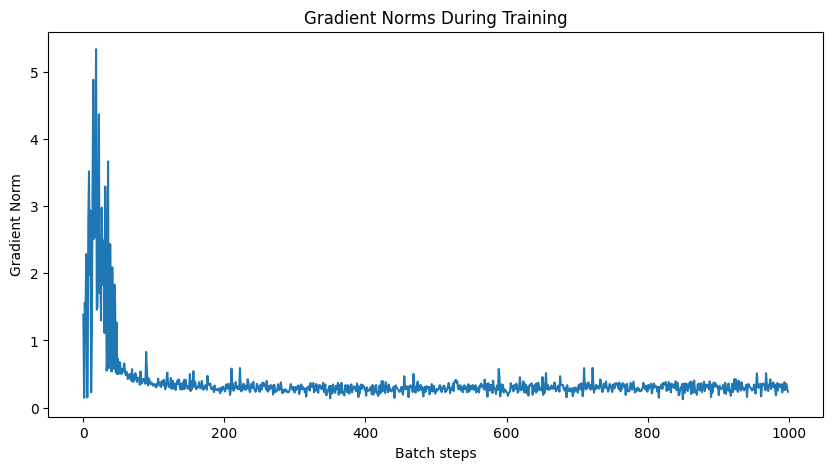

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

max_length = 500
batch_size = 2
epochs = 2
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256

train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, collate_fn=partial(collate_fn, max_length=max_length))
print("Number of batches in an epoch:", len(train_loader))
for batch in train_loader:
    print("input_ids shape:", batch['input_ids'].shape)
    print("targets shape:", batch['targets'].shape)
    break

model = LSTMModel(vocab_size, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss, perplexity, grad_norms = train(model, train_loader, criterion, optimizer, epochs=epochs, device=device)

plt.figure(figsize=(10, 5))
plt.plot(grad_norms, label='Gradient Norm')
plt.xlabel('Batch steps')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training')
plt.show()

In [11]:
val_subset = Subset(dataset["validation"], torch.arange(1000))
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, collate_fn=partial(collate_fn, max_length=max_length))


def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_examples = 0
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in dataloader:
            # Prepare inputs and targets
            targets = batch['targets'].contiguous().to(device)
            input_ids = batch['input_ids'].contiguous().to(device)

            # Forward pass
            outputs, _ = model(input_ids)
            outputs = outputs.reshape(-1, outputs.size(-1))
            targets = targets.reshape(-1)

            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item() * input_ids.size(0)
            total_examples += input_ids.size(0)

    average_loss = total_loss / total_examples
    perplexity = torch.exp(torch.tensor(average_loss))
    return average_loss, perplexity

evaluate_model(model, val_loader, criterion)

(4.692819959640503, tensor(109.1606))

In [12]:
val_batch = next(iter(val_loader))
preds, _ = model(val_batch['input_ids'][0].to(device))
targets = val_batch['targets'][0].to(device)
preds.shape

torch.Size([499, 50257])

In [13]:
[x.replace('Ġ', '') for x in tokenizer.convert_ids_to_tokens(targets)][:100]

['uster',
 'comprises',
 'IBM',
 "'s",
 'Op',
 'ter',
 'on',
 '-',
 'bs',
 'ed',
 'e',
 'Server',
 '325',
 'server',
 'n',
 'd',
 'systems',
 'm',
 'ng',
 'ement',
 'soft',
 'w',
 're',
 'n',
 'd',
 'st',
 'orge',
 'devices',
 'th',
 't',
 'c',
 'n',
 'run',
 'Linux',
 'n',
 'd',
 'Windows',
 'oper',
 'ting',
 'systems',
 '.',
 'Ċ',
 'IB',
 'M',
 'on',
 'Tues',
 'dy',
 'n',
 'n',
 'ounced',
 '',
 'prep',
 'ck',
 'ged',
 'n',
 'd',
 'pret',
 'ested',
 'cluster',
 'th',
 't',
 'is',
 'powered',
 'by',
 'Adv',
 'n',
 'ced',
 'Micro',
 'Devices',
 'Inc',
 '.',
 's',
 '64',
 '-',
 'bit',
 'Op',
 'ter',
 'on',
 'processor',
 '.',
 'Ċ',
 'IB',
 'M',
 'of',
 'Ar',
 'mon',
 'k',
 'N',
 '.',
 'Y',
 '.',
 'is',
 'combining',
 'its',
 'Op',
 'ter',
 'on',
 '-',
 'bs',
 'ed']

In [14]:
[x.replace('Ġ', '') for x in tokenizer.convert_ids_to_tokens(preds.argmax(dim=-1))][:100]

['l',
 'âĢ',
 '-',
 'the',
 '',
 'n',
 'the',
 'n',
 'old',
 'ed',
 'to',
 'ch',
 'the',
 '.',
 'n',
 'd',
 'the',
 'n',
 'de',
 'ement',
 '.',
 'the',
 'rd',
 'to',
 'd',
 'the',
 'te',
 '.',
 '.',
 't',
 'the',
 'n',
 'be',
 'of',
 'the',
 'd',
 'the',
 'the',
 'tion',
 'the',
 '.',
 'Ċ',
 'The',
 'âĢ',
 'the',
 'the',
 'dy',
 '.',
 'd',
 'ounced',
 'the',
 'new',
 'of',
 'to',
 '.',
 'd',
 'the',
 'the',
 'the',
 'n',
 't',
 'the',
 '',
 'to',
 'the',
 'n',
 '.',
 '.',
 '.',
 '.',
 '.',
 'Ċ',
 '.',
 'the',
 'old',
 '-',
 'm',
 'n',
 'n',
 'n',
 'Ċ',
 'The',
 'âĢ',
 'h',
 'the',
 'n',
 'âĢ',
 'the',
 'tion',
 'Ċ',
 '.',
 'Ċ',
 '',
 't',
 '',
 'n',
 'the',
 'n',
 'old',
 'ed']